# SchrodingerEq.jl

A project for the Computational Physics UW course (module III), by Laura Sberna.

We upload the necessary packages and set some parameters:

In [5]:
using LinearAlgebra
using Plots

In [6]:
m = 25.
hbar = 1.
t0 = 0.

0.0

## PLC Functions

I use the Piecewise Linear Continuous functions discussed in lecture (numer, link to github). 

In [7]:
struct PLCFun{T,U}
    points::Vector{U}
end

In [8]:
function Base. *(a::U, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
 PLCFun{T,U}(a .* f.points)
end

function Base. +(g::PLCFun{T,U}, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    @assert length(f.points) == length(g.points) ## gives error message if not satisfied
 PLCFun{T,U}(g.points .+ f.points)
end

In [9]:
function xcoord(::Type{T}, nlines::Int, i::Int)::T where {T,U}
    dx = 1 / nlines
    @assert 1 <= i <= nlines+1
    x = (i-1) * dx
    x
end

xcoord (generic function with 1 method)

In [10]:
function lineindex(f::PLCFun{T,U}, x::T)::Int where {T,U}
    @assert 0 <= x <= 1
    nlines=length(f.points)-1
    dx = 1 / nlines
    i = floor(Int, x / dx) + 1
    i = max(1,i)
    i = min(nlines, i)
    i
end

lineindex (generic function with 1 method)

In [11]:
function samplePLC(::Type{T}, ::Type{U}, nlines::Int, f::Function)::PLCFun{T,U} where {T,U}
    ys = U[f(xcoord(T, nlines, i)) for i in 1:nlines+1]
    PLCFun{T,U}(ys)
end

samplePLC (generic function with 1 method)

In [12]:
function linterp(x1::T, y1::U, x2::T, y2::U, x::T)::U where {T,U}
    y1 * (x - x2) / (x1 - x2) + y2 * (x - x1) / (x2 - x1)
end

linterp (generic function with 1 method)

In [13]:
function evaluate(f::PLCFun{T,U}, x::T)::U where {T,U}
    @assert 0 <= x <= 1
    nlines=length(f.points)-1
    i = lineindex(f, x)
    x1=xcoord(T, nlines, i)
    x2=xcoord(T, nlines, i+1)
    y1=f.points[i]
    y2=f.points[i+1]
    y = linterp(x1, y1, x2, y2, x)
    y
end

evaluate (generic function with 1 method)

The second order central finite diferrence scheme for the second order derivative is obtained as follows. We write the Taylor expansions
\begin{align}
f(x_{j-1})&=f(x_j)-\Delta x f'(x_j) + \frac{\Delta x^2}{2} f''(x_j) + O(\Delta x ^3)\\ 
f(x_{j})&=f(x_j) \\
f(x_{j+1})&=f(x_j)+\Delta x f'(x_j) + \frac{\Delta x^2}{2} f''(x_j) + O(\Delta x ^3) \\ 
\end{align}
from which
\begin{equation}
f''(x_j) = \frac{f(x_{j+1}) -2f(x_{j}) + f(x_{j-1})}{\Delta x^2} + O(\Delta x ^3) 
\end{equation}
We also put the system in a box: at the endpoints, we use the left or right scheme and set $f(boundary)=0$:
\begin{align}
f''(x_j) &= \frac{ f(x_{j+2})-2 f(x_{j+1}) }{\Delta x^2} + O(\Delta x ^3)  \ \ \ (left \ boundary) \\
f''(x_j) &= \frac{f(x_{j-2})-2 f(x_{j-1}) }{\Delta x^2} + O(\Delta x ^3)  \ \ \ (right \  boundary)
\end{align}

In [14]:
function derivSecondCenter(f::PLCFun{T,U})::PLCFun{T,U} where {T,U} 
    nlines=length(f.points)-1
    dx = 1 / nlines
    ys=U[(f.points[3] - 2*f.points[2] + f.points[1]) /(dx^2) ;[(f.points[i+1] - 2*f.points[i] + f.points[i-1]) /(dx^2) for i in 2:nlines]; (f.points[end-2] - 2*f.points[end-1] + f.points[end]) /(dx^2)]
    PLCFun{T,U}(ys)
end

derivSecondCenter (generic function with 1 method)

## The Schroedinger equation

Implicit methods for parabolic equations require very small time steps. For this reason it is better to implement higher order time integrators than Euler, like Runge-Kutta 2 or 4.

In [17]:
struct WaveFunction{T, U}
    time::T
    psi::PLCFun{T,U}
end

In [18]:
function Base. *(a::U, f::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
 WaveFunction{T, U}(f.time, a * f.psi)
end

function Base. *(v::PLCFun{T,Float64}, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    @assert length(v.points)==length(f.points)
    PLCFun{T,U}(v.points .* f.points)
end

function Base. +(g::WaveFunction{T, U}, f::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    @assert abs(f.time - g.time) <= 100*eps(T)
 WaveFunction{T, U}(f.time, g.psi + f.psi)
end

In [19]:
function gaussian(x::T, x0::T, sigmax::T, p::T)::Complex{Float64} where {T}
    1 / sqrt(sqrt(pi * sigmax^2)) * exp( - (x-x0)^2 / ( 2 * sigmax^2 ) + im * p * (x-x0))
end

gaussian (generic function with 1 method)

In [20]:
# exact solution for the free particle with Gaussian initial state
psianalyticsol(x,t) = 1 /pi^(1/4) / sqrt(sigmax + im*hbar*t /(m*sigmax)) * exp(- im * t*p^2 / (2*m) + im * p * (x-x0) - (x -x0 - hbar*p*t/m)^2/(2*(sigmax^2 + im*hbar*t / m)) )

psianalyticsol (generic function with 1 method)

In [21]:
function initialGaussian(nlines::Int, x0::Float64, sigmax::Float64, p::Float64)::WaveFunction{Float64, Complex{Float64}}
    t = 0
    y = samplePLC(Float64, Complex{Float64}, nlines, x -> gaussian(x,x0,sigmax,p))
    WaveFunction{Float64, Complex{Float64}}(t,y)
end

initialGaussian (generic function with 1 method)

In [22]:
function potential(nlines::Int)::PLCFun{Float64,Float64}
    samplePLC(Float64, Float64, nlines,V)
end

potential (generic function with 1 method)

In [23]:
function rhsSchroedinger(s::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    t = s.time
    psi = s.psi
    nlines = length(psi.points) - 1
    psixx = (- im / hbar) * ((- hbar^2 / ( 2*m) + im * 0.) * derivSecondCenter(psi) + potential(nlines) * psi)
    psit = PLCFun{T,U}(U[0;[psixx.points[i] for i in 2:nlines]; 0])
    WaveFunction{T, U}(t, psit)
end

rhsSchroedinger (generic function with 1 method)

In [24]:
function euler(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    r0 = rhs(s0)
    s1 = s0 + (dt + im * 0.)  * r0
    WaveFunction{T, U}(r0.time + dt, s1.psi)
end

euler (generic function with 1 method)

In [25]:
function RK2(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    r0 = rhs(s0)
    smiddle = s0 + (dt / 2 + im * 0.)  * r0
    rmiddle = rhs(smiddle)
    s1 = s0 + (dt + im * 0.)  * rmiddle
    WaveFunction{T, U}(r0.time + dt, s1.psi)
end

RK2 (generic function with 1 method)

In [26]:
function RK4(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    k1 = rhs(s0)
    k2 = rhs(s0 + (dt / 2 + im * 0.)  * k1)
    k3 = rhs(s0 + (dt / 2 + im * 0.)  * k2)
    k4 = rhs(s0 + (dt  + im * 0.)  * k3)
    s1 = s0 + (dt / 6 + im * 0.)  * (k1 + (2. + im * 0.) *k2 + (2. + im * 0.) *k3 + k4)
    WaveFunction{T, U}(s0.time + dt, s1.psi)
end

RK4 (generic function with 1 method)

In [27]:
struct solution{T,U}
    dt::T
    dx::T
    states::Vector{WaveFunction{T, U}}
end

In [28]:
function solveSchrodinger(tmax::T, nlines::Int, lambda::T, x0::T, sigmax::T, p::T) where {T}
    s=initialGaussian(nlines, x0, sigmax, p)
    dx= 1/nlines
    dt=lambda * dx
    nsteps= round(Int, tmax / dt)
    sol = solution{T,Complex{T}}(dt, dx, WaveFunction{T, Complex{T}}[])
    push!(sol.states, s)
    
    for step in 1:nsteps
        s = RK4(rhsSchroedinger, dt, s)
        push!(sol.states, s)
    end
    return sol
end

solveSchrodinger (generic function with 1 method)

In [29]:
function refine(u::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    nlines = length(u.points) - 1
    dx = 1 / nlines
    eval = [evaluate(u, xcoord(T, 2 * nlines, i)) for i in 1:2*nlines+1]
    PLCFun{T,U}(eval)
end

refine (generic function with 1 method)

In [30]:
function totprob(u::PLCFun{T,U}, dx::T)::T where {T,U}
    dx*sum(abs.(u.points) .^2)
end

totprob (generic function with 1 method)

## Barrier in a box

We introduce a potential square barrier,
\begin{equation}
V(x)= \begin{cases}
&0 \ \ \ \ if \ \ x< x_1, \ \ x>x_2 \\
&V_0 \ \ \ \ if \ \ x_1<x<x_2
\end{cases}
\end{equation}

When the energy of the particle is mostly smaller than the barrier height, $E = p^2/2m < V_0 $, quantum tunnelling will happen.

In [31]:
function V(x::T)::Float64 where {T}
    if x<0.35 || x>0.45 return 0. 
        else return 50.
    end
end

V (generic function with 1 method)

In [42]:
x0 = 0.25
sigmax = 0.05
p = 40.
n = 500
T = 0.21
lambda = 0.01  
xs = collect(range(0, stop=1, length=n))
sol1 = solveSchrodinger(T, n, lambda, x0, sigmax, p);

In [43]:
p^2/(2*m), V(0.4)  # checking that E < V_0

(32.0, 50.0)

### Comparison with Suzuki-Trotter solver

In [59]:
s = read(open("finalslice.txt"), String)
STfinal = parse.(Float64, split(s, '\n'));

In [91]:
allslices=nothing

In [96]:
s = read(open("allslices.txt"), String);
allslices = parse.(Float64, split(s, '\n'));

In [97]:
s = read(open("allslices.txt"), String);
test = parse.(Float64, split(s, '\n'));

In [93]:
allslices = reshape(allslices, Int64(length(allslices)/length(STfinal)), length(STfinal));

In [99]:
Int64(length(allslices))/length(STfinal)

10500.0

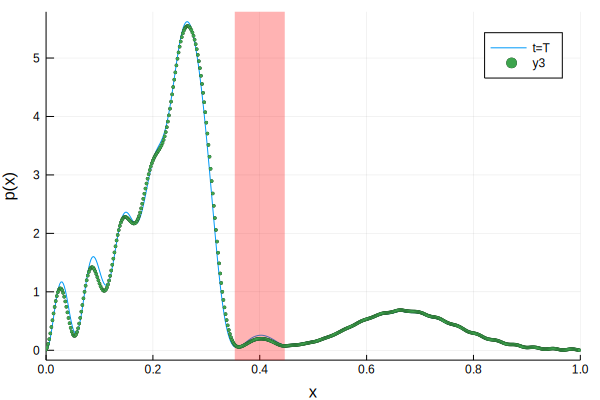

In [101]:
plot(xs, [abs(evaluate(sol1.states[end].psi, x))^2 for x in xs], 
    xlabel = "x", ylabel = "p(x)", label = "t=T")
plot!([0.4], seriestype = :vline, 
    linealpha=0.3, xlim=(0,1), line = (:red, 50), label = "")
#plot!(collect(range(0, stop=1, length=n+1)), allslices[:,end], seriestype=:dots,
#markersize =2, markerstrokewidth = 0.1)
plot!(collect(range(0, stop=1, length=n+1)), test[(10500 - 1) * 501 + 1 : 10500 * 501], seriestype=:dots,
markersize =2, markerstrokewidth = 0.1)

In [103]:
xs = collect(range(0, stop=1, length=Int64(n/4)))
@gif for i=1:length(sol1.states)-1
    plot(xs, [abs(evaluate(sol1.states[i].psi, x))^2 for x in xs], xlabel = "x", ylabel = "p(x)", legend = :false, 
    xlim = (0,1), ylim = (0,9))
    plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
        linecolor= :black, linealpha= 0.8)
    plot!(xs,[abs(psianalyticsol(x,i*lambda/n))^2 for x in xs], linestyle= :dash, linealpha= 0.6)
    plot!([0.4], seriestype = :vline, 
    linealpha=0.3, xlim=(0,1), line = (:red, 50))
    plot!(collect(range(0, stop=1, length=n+1)), test[(i - 1) * 501 + 1 : i * 501], seriestype=:dots,
markersize =2, markerstrokewidth = 0.1)
    end every 200

┌ Info: Saved animation to 
│   fn = /Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif
└ @ Plots /Users/laurasberna/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif")